In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import sklearn.metrics

# Generate classes
parameters to play with: **N**, **prevalence**

,x,class
0,3.077608,True
1,-1.044228,True
2,2.794176,True
3,1.988844,True
4,0.217132,True
...,...,...
495,0.536485,False
496,1.419156,False
497,-0.921203,False
498,-0.151247,False


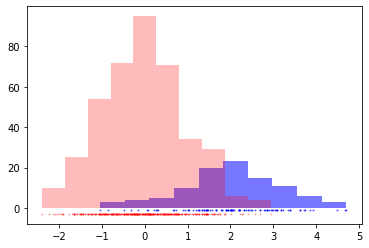

In [2]:
N = 500
prevalence = 0.2
c1 = np.random.normal(size=int(N*prevalence)) + 2
c2 = np.random.normal(size=int(N - N*prevalence))
c1 = np.vstack([c1, np.full_like(c1, True)]).T
c2 = np.vstack([c2, np.full_like(c2, False)]).T
plt.hist(c1[:,0], color='#00f8')
plt.hist(c2[:,0], color='#f004')
plt.scatter(c1[:,0], np.full(len(c1), -1), color='#00f8', s=1)
plt.scatter(c2[:,0], np.full(len(c2), -3), color='#f004', s=1)
d = np.vstack([c1, c2])
df = pd.DataFrame({'x': d[:,0], 'class': d[:,1] == 1})
df

# Detect class1 (blue) by value of x
parameters to play with: **threshold**

,x,class,test
0,3.077608,True,True
1,-1.044228,True,False
2,2.794176,True,True
3,1.988844,True,True
4,0.217132,True,False
...,...,...,...
495,0.536485,False,False
496,1.419156,False,True
497,-0.921203,False,False
498,-0.151247,False,False


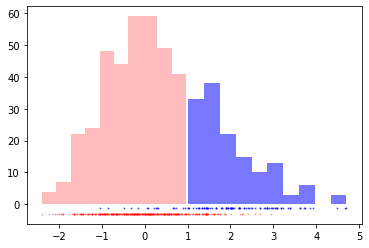

In [3]:
threshold = 1
df['test'] = df['x'] > threshold
t1_idx = df['test']
t1 = df[t1_idx]
t2 = df[~t1_idx]
t1, t2
plt.hist(t1['x'], color='#00f8')
plt.hist(t2['x'], color='#f004')
plt.scatter(c1[:,0], np.full(len(c1), -1), color='#00f8', s=1)
plt.scatter(c2[:,0], np.full(len(c2), -3), color='#f004', s=1)
df

## Contingency table

In [4]:
cont_tbl = df.pivot_table(index='test', columns='class', values='x', aggfunc='count')
cont_tbl = cont_tbl.append(pd.DataFrame(index=[''], data=[cont_tbl.sum().values]))
cont_tbl[''] = cont_tbl.sum(axis=1)

cont_tbl.columns = pd.MultiIndex.from_product([['-', '+', '']], names=['actual'])
cont_tbl.index = pd.MultiIndex.from_product([['test-', 'test+', '']], names=['test'])
cont_tbl

actual,-,+,
test,,,
test-,341,16,357
test+,59,84,143
,400,100,500


## Rates table

In [5]:
rates_tbl = cont_tbl.iloc[:2,:2] / cont_tbl.iloc[2,:2]
rates_tbl['LR'] = rates_tbl['+'].values / rates_tbl['-'].values
rates_tbl

actual,-,+,LR
test,,,
test-,0.8525,0.16,0.187683
test+,0.1475,0.84,5.694915


## Predictive values table

In [6]:
pred_vals_tbl = (cont_tbl.T.iloc[:2,:2] / cont_tbl.T.iloc[2,:2]).T
pred_vals_tbl

actual,-,+
test,,
test-,0.955182,0.044818
test+,0.412587,0.587413


## All statistics

In [7]:
p = df['class'].sum()
n = (~df['class']).sum()
tp = (df['class'] & df['test']).sum()
tn = (~df['class'] & ~df['test']).sum()
fp = (~df['class'] & df['test']).sum()
fn = (df['class'] & ~df['test']).sum()
p_ = df['test'].sum()
n_ = (~df['test']).sum()
tpr = tp / p
fnr = 1 - tpr
tnr = tn / n
fpr = 1 - tnr
ppv = tp / p_
npv = tn / n_
fdr = fp / p_
fo_rate = fn / n_
calc_pt = lambda tpr, tnr: (np.sqrt(tpr*(-tnr+1))+tnr-1) / (tpr+tnr-1)
pt = calc_pt(tpr, tnr)
ts = tp / (tp+fn+fp)
acc = (tp+tn) / (p+n)
ba = (tpr+tnr) / 2
f1 = 2 * (ppv*tpr) / (ppv+tpr)
informedness = tpr + tnr - 1
markedness = ppv + npv - 1

stats = [
    ['population', N, ''],
    ['prevalence', prevalence, ''],
    ['threshold', threshold, ''],
    ['true positive (TP)', tp, r'$$$$'],
    ['false positive (FP)', fp, ''],
    ['false negative (FN)', fn, ''],
    ['true negative (TN)', tn, ''],
    ['sensitivity, recall, true positive rate (TPR)', tpr, r'$TPR=\frac{TP}{P}=\frac{TP}{TP+FN}=1-FNR$'],
    ['false positive rate (FPR)', fpr, ''],
    ['false negative rate (FNR)', fnr, ''],
    ['specificity, true negative rate (TNR)', tnr, r'$TNR=\frac {TN }{TN +FP} =\frac {TN}{N}$'],
    ['precision, positive predictive value (PPV)', ppv, r'$PPV =\frac {TP}{TP +FP}=1-FDR$'],
    ['false discovery rate (FDR)', fdr, ''],
    ['false omission rate (FOR)', fo_rate, r''],
    ['negative predictive value (NPV)', npv, ''],
    ['prevalence threshold (PT)', pt, r'$PT=\frac{\sqrt {TPR (-TNR+1)}+TNR-1}{TPR+TNR-1}$'],
    ['threat score (TS)', ts, r'$TS =\frac {TP}{TP + FN +FP }$'],
    ['accuracy (ACC)', acc, r'$ACC =\frac {TP +TN }{P +N}$'],
    ['balanced accuracy (BA)', ba, r'$BA =\frac {TPR+TNR}{2}$'],
    ['F1 score (F1)', f1, r'$F_{1}=2\cdot \frac { PPV \cdot TPR }{PPV +TPR }$'],
    ['informedness (BM)', informedness, r'$\mathrm {BM} =TPR +TNR -1=TPR-FPR $'],
    ['markedness (MK)', markedness, r'$\mathrm {MK} =\mathrm {PPV} +\mathrm {NPV} -1$'],
]
stats = pd.DataFrame(columns=['statistic', 'value', 'formula'], data=stats, index=range(1, len(stats)+1))
stats

,statistic,value,formula
1,population,500.000000,
2,prevalence,0.200000,
3,threshold,1.000000,
4,true positive (TP),84.000000,$$$$
5,false positive (FP),59.000000,
6,false negative (FN),16.000000,
7,true negative (TN),341.000000,
8,"sensitivity, recall, true positive rate (TPR)",0.840000,$TPR=\frac{TP}{P}=\frac{TP}{TP+FN}=1-FNR$
9,false positive rate (FPR),0.147500,
10,false negative rate (FNR),0.160000,


### Prevalence threshold ($d\mathrm{PPV}(\mathrm{prevalence})/d\mathrm{prevalence}=1$)
$PPV = \frac {TP}{TP+FP} = \frac {population \cdot prevalence \cdot TPR}{population \cdot prevalence \cdot TPR + population \cdot (1-prevalence) \cdot FPR}$

Text(0.295298654347958, 0, 'prevalence threshold (PT) 0.30')

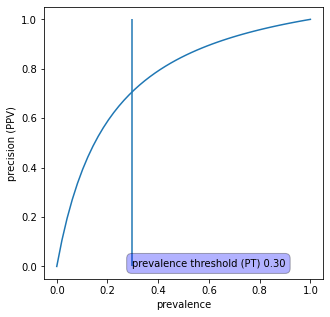

In [8]:
prevalences = np.linspace(0, 1, 50)
def calc_ppv(prev, tpr, fpr):
    return (prev*tpr) / (prev*tpr + (1-prev)*fpr)
ppvs = calc_ppv(prevalences, tpr, fpr)

fig, ax = plt.subplots(figsize=(5,5))
ax.plot(prevalences, ppvs)
ax.vlines([pt], ymin=0, ymax=1)
ax.set_xlabel('prevalence')
ax.set_ylabel('precision (PPV)')

fig.axes[0].annotate('prevalence threshold (PT) %.2f' % pt, xy=[pt, 0], fontsize=10,
                    bbox=dict(boxstyle='round,pad=0.5', fc='blue', alpha=0.30))

## Receiver operating characteristic (ROC) - TPR/FPR curve
the curve doesn't depend on prevalence so should be identical for class and ~class??

Text(0.14749999999999996, 0.49374999999999997, 'informedness (BM, J) 0.69')

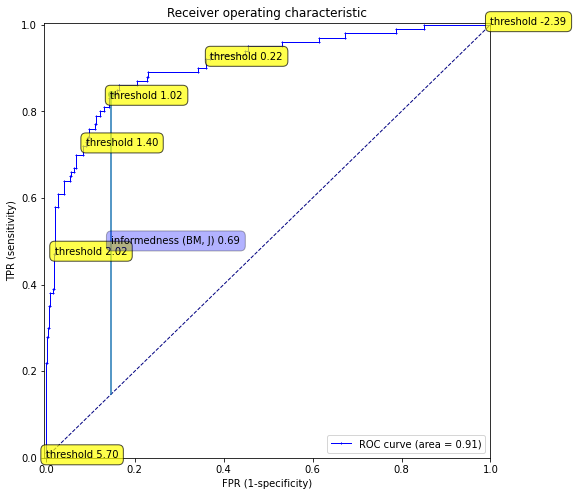

In [9]:
def plot_roc(y_true, y_score):
    fprs, tprs, thrs = sklearn.metrics.roc_curve(y_true, y_score)
    roc_auc = sklearn.metrics.auc(fprs, tprs)

    fig = plt.figure(figsize=(8, 8))
    plt.plot(fprs, tprs, color='blue', marker='+', ms=1.2, lw=1, 
             label='ROC curve (area = %0.2f)' % roc_auc)
    # plt.step(fprs, tprs, where='post', color='blue', marker='o', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--') # diagonal
    plt.xlim([-0.004, 1.0]) # small shift makes the whole ROC line visible
    plt.ylim([0.0, 1.004])
    plt.xlabel('FPR (1-specificity)')
    plt.ylabel('TPR (sensitivity)')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    
    num_labels = 6
    labels_idx = np.linspace(0, len(thrs)-1, num_labels).astype(int)
    for i in labels_idx:
        fpr, tpr, thr = fprs[i], tprs[i], thrs[i]
        fig.axes[0].annotate('threshold %.2f' % thr, xy=[fpr, tpr], fontsize=10,
                            bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.70))
    return fig
        
fig = plot_roc(df['class'], df['x'])

plt.scatter([fpr], [tpr])
plt.plot([fpr, fpr], [fpr, tpr])
fig.axes[0].annotate('informedness (BM, J) %.2f' % informedness, xy=[fpr, (tpr-fpr)/2+fpr], fontsize=10,
                    bbox=dict(boxstyle='round,pad=0.5', fc='blue', alpha=0.30))

## Precision/recall curve
- precision depends on prevalence so the curve is different for class and ~class if prevalence is not 0.5
- впадины с последущими подъемами появляются когда порог движется и захватывает ~class - полнота не меняется, но падает точность; затем попадаются class и точность возрастает

F1 score(F1) 0.691358024691358


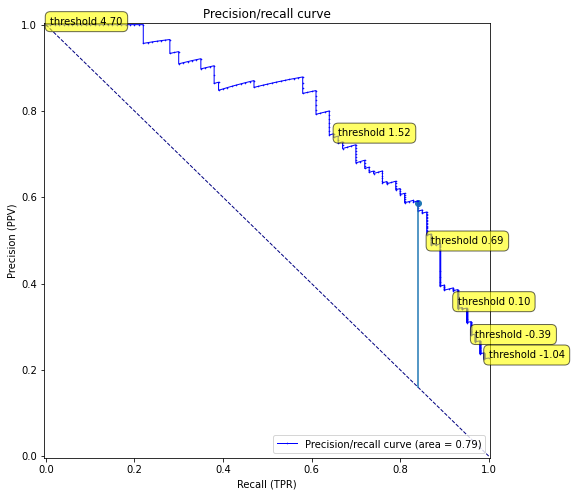

In [10]:
def plot_precision_recall(y_true, y_score):
    precs, recs, thrs = sklearn.metrics.precision_recall_curve(y_true, y_score)
    roc_auc = sklearn.metrics.auc(recs, precs)

    fig = plt.figure(figsize=(8, 8))
    plt.plot(recs, precs, color='blue', marker='.', ms=1.2, lw=1, 
             label='Precision/recall curve (area = %0.2f)' % roc_auc)
    # plt.step(fprs, tprs, where='post', color='blue', marker='o', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [1, 0.0], color='navy', lw=1, linestyle='--') # diagonal
    plt.xlim([-0.004, 1.004]) # small shift makes the whole ROC line visible
    plt.ylim([-0.004, 1.004])
    plt.xlabel('Recall (TPR)')
    plt.ylabel('Precision (PPV)')
    plt.title('Precision/recall curve')
    plt.legend(loc="lower right")
    
    num_labels = 6
    labels_idx = np.linspace(0, len(thrs)-1, num_labels).astype(int)
    for i in labels_idx:
        prec, rec, thr = precs[i], recs[i], thrs[i]
        fig.axes[0].annotate('threshold %.2f' % thr, xy=[rec, prec], fontsize=10,
                            bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.60))
    return fig
        
fig = plot_precision_recall(df['class'], df['x'])

plt.scatter([tpr], [ppv])
plt.plot([tpr, tpr], [1-tpr, ppv])
# fig.axes[0].annotate('F1 score (F1) %.2f' % f1, xy=[tpr, (ppv-(1-tpr))/2+(1-tpr)], fontsize=10,
#                     bbox=dict(boxstyle='round,pad=0.5', fc='blue', alpha=0.30))
print('F1 score(F1)', f1)